# Hotel Booking Demand 
* source_data_link : 
<br> https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand 


## 1- Importing libraries 

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline


## 2- Loading & Cleaning

In [30]:
# Loading the data and general info
df = pd.read_csv('/home/omar22/Downloads/hotel_bookings.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [31]:
# Checking for duplicates
print( df.duplicated().sum() )

df = df.drop_duplicates()


31994


In [32]:
# Specific look on NaNs 
nan_tuples = [( col ,  nan_s ) for col in df.columns if ( nan_s := df[col].isnull().sum() ) !=0]   # := is for assignment inside list comprehension
print(nan_tuples)



# 'company' has too much NaNs & 'agent' IDs aren't understandable
df = df.drop(columns=["company","agent"],axis=1) 

# 'children' NaNs are imputed using the median
df.children.describe() 
df.loc[df['children'].isna()  , 'children' ] = 0

# 'country' NaNs are imputed using the most frequent item 'it is also the origin of the hotels (Portugal)'
df.country.describe() 
df.loc[df['country'].isna()  , 'country' ] = 'PRT'


[('children', 4), ('country', 452), ('agent', 12193), ('company', 82137)]


## 3- Primary asked questions
* what is the best time of the year of booking a hotel that leads to higher adr?
* which maxmim period of stay that leads to maximum daily rate and longer than such period may be costy?

#### Analysing the 1st question:
* ---> what is the best time of the year of booking a hotel that leads to higher adr?


In [33]:
# As we interested in 'adr' as it helps answering the first question...so we must validate it.
'''
    since, df['adr'] = transaction / num_staying_nights 
    1- so, cannot calculated when total_stays = 0
    2- also, it cannot contain (-ve values) 
'''

df['persons'] = df['adults'] + df['children'] + df['babies']
df['stays'] = df['stays_in_week_nights'] + df['stays_in_weekend_nights']


# we make new_data that has total_stays != 0
nonzero_stays = df[~(df['stays']==0)]

# check for the non-negative 'adr' for the new data
nonzero_stays['adr'].describe()
nonzero_stays= nonzero_stays[nonzero_stays['adr'] > 0 ] 
nonzero_stays.shape

(85617, 32)

In [34]:
y = nonzero_stays.groupby(by = ['arrival_date_year','arrival_date_month','hotel']).agg({'adr':'mean'}).sort_values(by='adr',ascending=False)
y

adr
arrival_date_year arrival_date_month hotel                   
2017              August             Resort Hotel  209.584310
2016              August             Resort Hotel  193.730295
2017              July               Resort Hotel  180.625597
2016              July               Resort Hotel  158.938239
2015              August             Resort Hotel  158.135132
2017              August             City Hotel    143.905138
                  May                City Hotel    138.031112
                  June               City Hotel    135.545852
                  July               City Hotel    130.679951
                  April              City Hotel    130.599204
2015              July               Resort Hotel  128.487228
2016              September          City Hotel    128.042268
                  August             City Hotel    125.492830
2017              June               Resort Hotel  121.096181
2016              July               City Hotel    119.409620
                  May                City Hotel    118.950691
                  October            City Hotel    116.966051
                  June               City Hotel    114.058034
                  September          Resort Hotel  111.876074
2015              September          City Hotel    111.741214
2016              April              City Hotel    105.529705
                  June               Resort Hotel  104.786230
                  December           City Hotel     99.909775
2015              October            City Hotel     99.159171
2016              November           City Hotel     97.739498
2017              March              City Hotel     97.329820
                  February           City Hotel     96.764997
2016              March              City Hotel     95.530927
2017              January            City Hotel     92.257847
2015              September          Resort Hotel   92.017283
2017              April              Resort Hotel   90.764453
                  May                Resort Hotel   89.206929
2015              August             City Hotel     88.157313
                  December           City Hotel     87.475384
2016              February           City Hotel     84.620136
                  January            City Hotel     78.282558
2015              November           City Hotel     76.790704
2016              May                Resort Hotel   74.916882
                  December           Resort Hotel   73.307204
2015              July               City Hotel     72.903702
2016              October            Resort Hotel   70.281732
                  April              Resort Hotel   69.949886
2015              December           Resort Hotel   62.395863
2017              March              Resort Hotel   60.440818
2015              October            Resort Hotel   59.337411
2016              March              Resort Hotel   57.551060
2017              February           Resort Hotel   57.246815
2016              February           Resort Hotel   52.901530
2017              January            Resort Hotel   52.617754
2016              November           Resort Hotel   52.339516
                  January            Resort Hotel   47.890948
2015              November           Resort Hotel   47.467180

#### From this analysis, it is concluded that:
* the adr increases Generally at Agust & July (summer) 
* the adr lowest value occurs generally at (winter) 
* the optimum value of average daily rate is about : 209.58 & it occurs at the resort hotels.

*****************************************

#### Analysing the 2nd question:
* ---> which maxmim period of stay that leads to maximum daily rate and longer than such period may be costy?

Transient          71986
Transient-Party    11727
Contract            3139
Group                544
Name: customer_type, dtype: int64

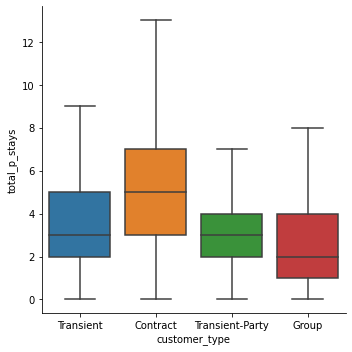

In [42]:
# to validate the data, we should plot the customer_type vs total_stays
# transient should have lower total_stays
df['stays'] = df['stays_in_week_nights'] + df['stays_in_weekend_nights']


sns.catplot(kind='box', data =df, y='stays', x='customer_type',showfliers = False)

df['customer_type'].value_counts()



#### From this analysis, it is concluded that:
* from this the maximum total stays the benefit the hotel is for "transient & transient_party" as they have the maximum weight among 'customer_type'
* needs more study with relatiom to the time & adr (but time is out) :(

In [35]:
# analysing the num_of stays depending on time

lis =[]
for col in df.columns:
    if ("arrival" in col):
        lis.append(col)
        df[col] = df[col].astype(str)


#print(lis)
df['arrival_date'] = df[lis[0]]+ " " + df[lis[1]] 
df = df.drop(columns=lis)
df['arrival_date']


x = df.groupby(by = ['stays','arrival_date']).agg({'is_canceled':'mean'}).sort_values(by='is_canceled',ascending =True)
x

is_canceled
stays arrival_date               
0     2015 August             0.0
15    2017 May                0.0
16    2015 September          0.0
      2016 April              0.0
      2016 July               0.0
...                           ...
24    2016 January            1.0
16    2016 January            1.0
19    2016 August             1.0
23    2015 October            1.0
26    2017 February           1.0

[566 rows x 1 columns]

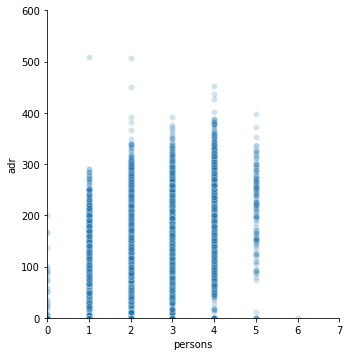

In [ ]:
sns.relplot(kind='scatter',x='persons', y ='adr',data=df,alpha=0.2)
plt.xlim(0,7)
plt.ylim(0,600)
plt.show()

In [ ]:
# dealing with nans




li = [(col,c) for col in df.columns if (c := df[col].nunique() )  < 5 ]
li


[('hotel', 2),
 ('is_canceled', 2),
 ('arrival_date_year', 3),
 ('is_repeated_guest', 2),
 ('deposit_type', 3),
 ('customer_type', 4),
 ('reservation_status', 3)]

In [ ]:
df['adr'].nunique()

8879

In [ ]:
df[['reservation_status_date', 'arrival_date']] = df[['reservation_status_date', 'arrival_date']].apply(pd.to_datetime)
df.dtypes
df.head()

,hotel,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,...,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date
0,Resort Hotel,0,342,0,0,2,0.0,0,BB,PRT,...,No Deposit,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01
1,Resort Hotel,0,737,0,0,2,0.0,0,BB,PRT,...,No Deposit,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01
2,Resort Hotel,0,7,0,1,1,0.0,0,BB,GBR,...,No Deposit,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01
3,Resort Hotel,0,13,0,1,1,0.0,0,BB,GBR,...,No Deposit,304.0,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01
4,Resort Hotel,0,14,0,2,2,0.0,0,BB,GBR,...,No Deposit,240.0,0,Transient,98.0,0,1,Check-Out,2015-07-03,2015-07-01


In [ ]:
df.groupby('hotel')

'''
relation between ("number of stays" & deposit-type & reservation_changes)

does higher number of changes in the booking leads to low number of stays)

we found also there is no-change in rooms when there is no-stays.
'''



SyntaxError: invalid syntax (435861781.py, line 3)